# Flocking

In [3]:
#First two lines are not needed if using installed version of EasyABM
using Pkg, Revise
Pkg.activate(joinpath(@__DIR__,"../.."))
using EasyABM


  Activating project at `~/Documents/EasyABM`


# Step 1: Create Agents and Model

Lets create 100 agents with properties `shape`, `pos`, `vel` and `orientation` (The `orientation` property is used internally by EasyABM to draw the direction agent is facing). The position `pos` is only accepted as a Vect which is an inbuilt vector type in EasyABM. It is also recommended for both convenience as well as performance to use Vect type for any vectorial properties in the model such as velocity and forces. The `keeps_record_of` argument is set of properties that the agent will record during time evolution. The model is defined with parameters:

* `min_dis` : The distance between boids below which they start repelling each other.
* `coh_fac` : The proportionality constant for the cohere force. 
* `sep_fac` : The proportionality constant for the separation force.
* `aln_fac` : The proportionality constant for the alignment force.
* `vis_range` : The visual range of boids.
* `dt` : The proportionality constant between change in position and velocity.

The argument `agents_type` is set to Static which means that the agents number will remain fixed during simulation.

In [4]:
boids = con_2d_agents(100, shape = :arrow, pos = Vect(0.0,0.0), 
    vel=Vect(0.0,0.0), orientation = 0.0, keeps_record_of = Set([:pos, :vel, :orientation]))
model = create_2d_model(boids,
    agents_type=Static, space_type = Periodic, 
    min_dis = 0.3, coh_fac = 0.05, 
    sep_fac = 0.5, dt= 0.1, vis_range = 2.0, aln_fac = 0.35)

EasyABM SpaceModel2D{EasyABM.StaticType, Float64, EasyABM.PeriodicType}: In a EasyABM.StaticType model number of agents is fixed.



## Step 2: Initialise the model

In this step we set the positions, velocities and orientations of boids and initialise the model.

In [5]:
function initialiser!(model)
    xdim, ydim = model.size
    for boid in model.agents
        boid.pos = Vect(rand()*xdim, rand()*ydim)
        boid.orientation = rand()*2*3.14
        boid.vel = vector_orientation(boid.orientation)
    end
end

init_model!(model, initialiser = initialiser!)

## Step 3: Defining the step_rule! and running the model

In this step we implement the step logic of the flocking model in the `step_rule!` function and run the model for 200 steps. 

In [6]:
ep = 0.00001 # can declare it as const for efficiency

1.0e-5

In [7]:
function step_rule!(model)
    dt = model.parameters.dt
    for boid in model.agents
        nbrs = neighbors(boid, model, model.parameters.vis_range)
        coh_force = Vect(0.0,0.0) # For a Vect all coordinates must be of same type
        sep_force = Vect(0.0,0.0) 
        aln_force = Vect(0.0,0.0)
        num = 0
        for nbr in nbrs
            num+=1
            vec = nbr.pos - boid.pos
            coh_force += vec
            if veclength(vec)< model.parameters.min_dis
                sep_force -= vec
            end
            aln_force += nbr.vel
        end
        aln_force = num>0 ? (aln_force / num - boid.vel) * model.parameters.aln_fac : aln_force
        num = max(1, num)
        coh_force *= (model.parameters.coh_fac / num)
        sep_force *=  model.parameters.sep_fac
        boid.vel  += (coh_force + sep_force) + aln_force
        boid.vel  /= (veclength(boid.vel)+ep)
        boid.orientation = calculate_direction(boid.vel)
        boid.pos += boid.vel*dt
    end
end

run_model!(model, steps=200, step_rule = step_rule!)

## Step 4: Visualisation

In order to draw the model at a specific frame, say 4th, one can use following function

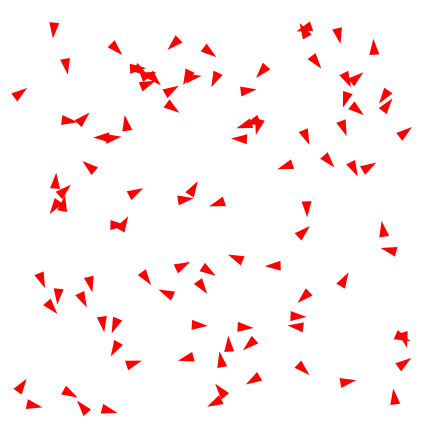

In [8]:
draw_frame(model, frame = 4 )

If one wants to see the animation of the last model run, it can be done as 

In [9]:
animate_sim(model)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["time"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 201, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable(101), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/home/dushya/.julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/home/dushya/.julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/home/dushya/.julia/packages/InteractBase/LJXv3/src/../assets/all.js"), WebIO.Asset("css", nothing, "/home/dushya/.julia/packages/InteractBase/LJXv3/src/../assets/style.css"), WebIO.Asset("css", nothing, "/home/dushya/.julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Base.GenericCondition{ReentrantLock}(Base.IntrusiveLinkedList{Task}(Task (runnable) @0x00007f1f70d6e400, Task (runnable) @0x00007f1f70d6e400), ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (0, 139773047660944, 139773847615808)))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\

After defining the `step_rule!` function we can also choose to create an interactive application (which currently works in Jupyter with WebIO installation) as 

In [10]:
create_interactive_app(model, initialiser= initialiser!,
    step_rule= step_rule!,
    model_controls=[(:min_dis, "slider", 0.01:0.1:1.0),
        (:coh_fac, "slider", 0.01:0.01:1.0),
        (:sep_fac, "slider", 0.01:0.01:1.0),
        (:aln_fac, "slider", 0.01:0.01:1.0),
        (:vis_range, "slider", 0.5:0.5:4.0)], frames=400) 

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["time"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 400, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable(1), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/home/dushya/.julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/home/dushya/.julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/home/dushya/.julia/packages/InteractBase/LJXv3/src/../assets/all.js"), WebIO.Asset("css", nothing, "/home/dushya/.julia/packages/InteractBase/LJXv3/src/../assets/style.css"), WebIO.Asset("css", nothing, "/home/dushya/.julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Base.GenericCondition{ReentrantLock}(Base.IntrusiveLinkedList{Task}(Task (runnable) @0x00007f1f70767d00, Task (runnable) @0x00007f1f70767d00), ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (0, 139773674765248, 139773674765248)))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n 

## Step 5: Fetch Data 

It is easy to fetch any data recorded during simulation. For example, the data of average velocity of agents at each time step can be obtained as - 

In [11]:
df = get_agents_avg_props(model, agent -> agent.vel, labels = ["average velocity"])

Row,average velocity
,Vect…
1,"(-0.0526797, 0.0562834)\n"
2,"(-0.0723846, 0.129933)\n"
3,"(-0.142997, 0.186249)\n"
4,"(-0.19616, 0.22809)\n"
5,"(-0.239176, 0.232076)\n"
6,"(-0.254415, 0.225635)\n"
7,"(-0.251186, 0.21427)\n"
8,"(-0.233704, 0.189064)\n"
9,"(-0.220455, 0.176988)\n"


Individual agent data recorded during model run can be obtained as 

In [12]:
df = get_agent_data(model.agents[1], model).record

Row,orientation,pos,vel
,Float64,Vect…,Vect…
1,3.52074,"(1.25185, 0.623397)\n","(0.370132, -0.928979)\n"
2,4.54489,"(1.35045, 0.606725)\n","(0.986, -0.166715)\n"
3,5.3389,"(1.43146, 0.665357)\n","(0.810068, 0.586318)\n"
4,5.71167,"(1.48555, 0.749465)\n","(0.540905, 0.841075)\n"
5,5.88384,"(1.52443, 0.841596)\n","(0.388809, 0.92131)\n"
6,5.93414,"(1.55863, 0.935565)\n","(0.341999, 0.939692)\n"
7,5.96886,"(1.58955, 1.03066)\n","(0.309169, 0.951)\n"
8,5.96821,"(1.62052, 1.12574)\n","(0.309788, 0.950798)\n"
9,5.97378,"(1.65097, 1.221)\n","(0.304488, 0.952509)\n"
